# DS 2500 – Module Assignment 3

Aaron Templeton

U0734119

In [0]:
# Most straight-forward way to import a library in Python
import requests

# BeautifulSoup is a module inside the "bs4" library, we only import the BeautifulSoup module
from bs4 import BeautifulSoup
# We import pandas but give the library a shortcut alias "pd" since we will call its functions so much
import numpy as np
import pandas as pd
import json
import time
import scipy
pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Scraping and parsing data from the web

I will look at Olympic Medalists for Cross Country Skiing for men and women in all events.

Start off with using `requests` to get the data from https://www.olympic.org/cross-country-skiing/mens-15km-free and then use `BeautifulSoup` to turn it into soup we can parse through.

In [70]:
url = "https://www.olympic.org/cross-country-skiing/mens-15km-free"
res = requests.get(url).text
soup = BeautifulSoup(res, 'html.parser')
soup


<!DOCTYPE html>

<html lang="en">
<head>
<title>Menâs 15km Free - Olympic Cross Country Skiing</title>
<meta charset="utf-8"/>
<meta content="Event" name="googlepagetype"/>
<meta content="{B8E0CB74-A976-4AF3-8779-9313E6B6CECE}" name="googlepageid"/>
<meta content="Access official Olympic photos, video clips, records and results for the top Cross Country Skiing medalists in the Menâs 15km Free event. " name="description"/>
<meta content="article" property="og:type"/>
<meta content="https://www.olympic.org/cross-country-skiing/mens-15km-free" property="og:url"/>
<meta content="2018-06-15T05:51:46+02:00" property="article:published_time"/>
<meta content="2018-06-15T05:51:46+02:00" property="article:modified_time"/>
<meta content="15km Free,Cross Country Skiing,Men " property="article:tag"/>
<meta content="209361989215" property="article:publisher"/>
<meta content="International Olympic Committee" property="og:site_name"/>
<meta content="209361989215" property="fb:admins"/>
<meta cont

Using the Inspect tool, the `<section class="event-box">` seems to be the most promising tag for us to extract. Use `.find_all('section',{'class':'event-box'})` to (hopefully!) get all of the events on the page. Inspect the first and last ones to make sure they looks coherent.

In [71]:
# Get all the groups that have a <div class="listing-group"> tag
events = soup.find_all('section', class_='event-box') 

# How many tags in total?
print(len(events))

# Inspect the first one
events[0]

14


<section class="event-box">
<h2>
<a href="/pyeongchang-2018/cross-country-skiing/mens-15km-free">
<i class="icon-arrow-right"></i>
                PyeongChang 2018
            </a>
</h2>
<table class="table3 alt">
<caption class="hide">table</caption>
<thead>
<tr>
<th class="col1">Result</th>
<th class="last">Participant</th>
</tr>
</thead>
<tbody>
<tr>
<td class="col1">
<div class="medal gold">
<span class="num">G</span>
</div>
<span class="txt">33:43.9</span>
</td>
<td class="col2">
<div class="profile-section">
<a href="/dario-cologna">
<span class="picture">
<span data-alt="image description" data-picture="">
<picture class="picture">
<img alt="COLOGNA Dario" srcset="https://stillmed.olympic.org/media/Images/OlympicOrg/Athletes/C/Cologna_Dario/Cologna_Dario_mugshot.jpg?interpolation=lanczos-none&amp;resize=45:45, https://stillmed.olympic.org/media/Images/OlympicOrg/Athletes/C/Cologna_Dario/Cologna_Dario_mugshot.jpg?interpolation=lanczos-none&amp;resize=90:90 2x"/>
<span class="mask

#Finding more specific elements in the HTML tree

we have found all of the events for a specific cross country race. Now we will check the event place and look at the relevant fields to get the information that we want out of the html

### Checking the relevant fields

It is critical that we write a parser that parses *only* the data we want and nothing else. Now that we have our events, let's break one open and extract all the yummy data waiting inside.

There are a few attributes in  `<h2'>` that has the tilte of the event.
there is also a table in each event section that holds the relevant information for the medalists.


* `<td class="col1" ><div class="medal"> <span class='num'>` - Medal Won
* `<td class="col1" ><span class="txt">` - time
* `<td class="col2"> <div class="text-box"><strong class="name">` - athlete name
* `<td class="col2"> <div class="text-box"><div class="profile-row"><span>` - athlete's country

In [72]:
soup.find_all('h1')[0].text

'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'

The name of the event

In [73]:
events[0].find_all('h2')[0].text.strip()

'PyeongChang 2018'

the Olympics location and year

In [0]:
tbody = events[0].find_all('tbody')

In [0]:
rows = tbody[0].find_all('tr')

the medal that was one (G, S, B)

In [76]:
rows[0].find('strong', class_='name').text

'Dario COLOGNA'

name of the athlete (first last)


In [77]:
rows[0].find('div', class_='profile-row').find('span').text

'SUI'

In [78]:
rows[0].find('span', class_='txt').text

'33:43.9'

country abreviation for athlete's country

### Writing the core parser functionality

How will we map the contents of the HTML to the 

* **Olympics**
* **Event**
* **Medal**
* **Name**
* **Country**
* **Time**

Now we can iterate over all the events and grab all the athletes data. However we don't want data for just a single event in cross country, we want all the cross country events at every olympics.

to get it, we will start at `https://www.olympic.org/cross-country-skiing` which has a link to every cross country event. We will fetch all the links and get the event data for each one. we dont want the team events or relay events so we will skip those urls

In [0]:
url = 'https://www.olympic.org/cross-country-skiing'
response = requests.get(url).text
soup = BeautifulSoup(response, 'html.parser')
sportevents = soup.find_all('section', class_='sport-events')

In [80]:
urls = []
base = 'https://www.olympic.org'
hrefs = sportevents[0].find_all('a')
for h in hrefs:
  url = base + h['href']
  if "relay" not in url and "team" not in url:
    urls.append(url)  
    print(url)

https://www.olympic.org/cross-country-skiing/mens-15km-free
https://www.olympic.org/cross-country-skiing/mens-15km-15km-skiathlon
https://www.olympic.org/cross-country-skiing/mens-50km-mass-start-classic
https://www.olympic.org/cross-country-skiing/mens-sprint-classic
https://www.olympic.org/cross-country-skiing/ladies-10km-free
https://www.olympic.org/cross-country-skiing/ladies-30km-mass-start-classic
https://www.olympic.org/cross-country-skiing/ladies-7-5km-7-5km-skiathlon
https://www.olympic.org/cross-country-skiing/ladies-sprint-classic


In [81]:

events_data = []

def parse(events, event_name):
  for event in events:
    olympics = event.find_all('h2')[0].text.strip()
    tbody = event.find('tbody')
    trs = tbody.find_all('tr')
    for row in trs:
      #print(row)
      medal = row.find('span', class_='num').text
      name = row.find('strong', class_='name').text
      country = row.find('div', class_='profile-row').find('span').text
      try:
        time = row.find('span', class_='txt').text
      except:
        time = "None"

      payload = {
          "Olympics" : olympics,
          "Medal" : medal,
          "Name": name,
          "Country" : country,
          "Time" : time,
          "Event" : event_name
      }

      events_data.append(payload)
      print(payload)

for url in urls:
  response = requests.get(url).text
  soup = BeautifulSoup(response, 'html.parser')
  events = soup.find_all('section', class_='event-box') 
  event_name = soup.find_all('h1')[0].text
  parse(events, event_name)

len(events_data)

{'Olympics': 'PyeongChang 2018', 'Medal': 'G', 'Name': 'Dario COLOGNA', 'Country': 'SUI', 'Time': '33:43.9', 'Event': 'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'}
{'Olympics': 'PyeongChang 2018', 'Medal': 'S', 'Name': 'Simen Hegstad KRUEGER', 'Country': 'NOR', 'Time': '34:02.2', 'Event': 'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'}
{'Olympics': 'PyeongChang 2018', 'Medal': 'B', 'Name': 'Denis SPITSOV', 'Country': 'OAR', 'Time': '34:06.9', 'Event': 'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'}
{'Olympics': 'Vancouver 2010', 'Medal': 'G', 'Name': 'Dario COLOGNA', 'Country': 'SUI', 'Time': '33:36.3', 'Event': 'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'}
{'Olympics': 'Vancouver 2010', 'Medal': 'S', 'Name': 'Pietro PILLER COTTRER', 'Country': 'ITA', 'Time': '34:00.9', 'Event': 'Cross-Country Skiing â\x80\x93 Menâ\x80\x99s 15km Free'}
{'Olympics': 'Vancouver 2010', 'Medal': 'B', 'Name': 'Lukas BAUER', 'Country': 'CZE', 'Time': '34:12.0', 'Ev

166

Turn into Dataframe

In [82]:
df = pd.DataFrame(events_data)
print('There are {0} rows and {1} columns'.format(df.shape[0], df.shape[1]))
df.head(5)

There are 166 rows and 6 columns


,Olympics,Medal,Name,Country,Time,Event
0,PyeongChang 2018,G,Dario COLOGNA,SUI,33:43.9,Cross-Country Skiing â Menâs 15km Free
1,PyeongChang 2018,S,Simen Hegstad KRUEGER,NOR,34:02.2,Cross-Country Skiing â Menâs 15km Free
2,PyeongChang 2018,B,Denis SPITSOV,OAR,34:06.9,Cross-Country Skiing â Menâs 15km Free
3,Vancouver 2010,G,Dario COLOGNA,SUI,33:36.3,Cross-Country Skiing â Menâs 15km Free
4,Vancouver 2010,S,Pietro PILLER COTTRER,ITA,34:00.9,Cross-Country Skiing â Menâs 15km Free


In [83]:
df.tail(5)

,Olympics,Medal,Name,Country,Time,Event
161,Sochi 2014,S,Ingvild Flugstad OESTBERG,NOR,2:34.18,Cross-Country Skiing â Ladiesâ Sprint Classic
162,Sochi 2014,B,Vesna FABJAN,SLO,2:34.13,Cross-Country Skiing â Ladiesâ Sprint Classic
163,Turin 2006,G,Chandra CRAWFORD,CAN,None,Cross-Country Skiing â Ladiesâ Sprint Classic
164,Turin 2006,S,Claudia NYSTAD,GER,None,Cross-Country Skiing â Ladiesâ Sprint Classic
165,Turin 2006,B,Alena SIDKO,RUS,None,Cross-Country Skiing â Ladiesâ Sprint Classic


#Clean up Dataset

we need to clean up the event column and check the other columns for null values

In [84]:
df['Event'] = df['Event'].map(lambda x: x.lstrip('Cross-Country Skiing â ').replace('â',''))
df.head(5)

,Olympics,Medal,Name,Country,Time,Event
0,PyeongChang 2018,G,Dario COLOGNA,SUI,33:43.9,Mens 15km Free
1,PyeongChang 2018,S,Simen Hegstad KRUEGER,NOR,34:02.2,Mens 15km Free
2,PyeongChang 2018,B,Denis SPITSOV,OAR,34:06.9,Mens 15km Free
3,Vancouver 2010,G,Dario COLOGNA,SUI,33:36.3,Mens 15km Free
4,Vancouver 2010,S,Pietro PILLER COTTRER,ITA,34:00.9,Mens 15km Free


In [85]:
df.isnull().sum().sort_values(ascending=False)

Event       0
Time        0
Country     0
Name        0
Medal       0
Olympics    0
dtype: int64

We have no null values!!

we will make a column for Gender to easily determine if its a mens or ladies event

In [86]:
df['Gender'] = df['Event'].apply(lambda x: "M" if "Mens" in x else "F")
df.head(5)

,Olympics,Medal,Name,Country,Time,Event,Gender
0,PyeongChang 2018,G,Dario COLOGNA,SUI,33:43.9,Mens 15km Free,M
1,PyeongChang 2018,S,Simen Hegstad KRUEGER,NOR,34:02.2,Mens 15km Free,M
2,PyeongChang 2018,B,Denis SPITSOV,OAR,34:06.9,Mens 15km Free,M
3,Vancouver 2010,G,Dario COLOGNA,SUI,33:36.3,Mens 15km Free,M
4,Vancouver 2010,S,Pietro PILLER COTTRER,ITA,34:00.9,Mens 15km Free,M


we will make a column for the year of the Olympic Games

In [87]:
df['Year'] = df['Olympics'].apply(lambda x: x[len(x)-4:len(x)])
df.head(5)

,Olympics,Medal,Name,Country,Time,Event,Gender,Year
0,PyeongChang 2018,G,Dario COLOGNA,SUI,33:43.9,Mens 15km Free,M,2018
1,PyeongChang 2018,S,Simen Hegstad KRUEGER,NOR,34:02.2,Mens 15km Free,M,2018
2,PyeongChang 2018,B,Denis SPITSOV,OAR,34:06.9,Mens 15km Free,M,2018
3,Vancouver 2010,G,Dario COLOGNA,SUI,33:36.3,Mens 15km Free,M,2010
4,Vancouver 2010,S,Pietro PILLER COTTRER,ITA,34:00.9,Mens 15km Free,M,2010


#Exploratory Data Analysis

Do countries that win the olympics produce more winners over time, in cross country skiing?

All of our data is scraped from the https://www.olympic.org/cross-country-skiing, the Olympics official website

#Check the Packaging

In [88]:
df.shape

(166, 8)

we expect 166 rows and 8 columns

#Look at the top and bottom of the data

In [89]:
df.head(5)

,Olympics,Medal,Name,Country,Time,Event,Gender,Year
0,PyeongChang 2018,G,Dario COLOGNA,SUI,33:43.9,Mens 15km Free,M,2018
1,PyeongChang 2018,S,Simen Hegstad KRUEGER,NOR,34:02.2,Mens 15km Free,M,2018
2,PyeongChang 2018,B,Denis SPITSOV,OAR,34:06.9,Mens 15km Free,M,2018
3,Vancouver 2010,G,Dario COLOGNA,SUI,33:36.3,Mens 15km Free,M,2010
4,Vancouver 2010,S,Pietro PILLER COTTRER,ITA,34:00.9,Mens 15km Free,M,2010


In [90]:
df.tail(5)

,Olympics,Medal,Name,Country,Time,Event,Gender,Year
161,Sochi 2014,S,Ingvild Flugstad OESTBERG,NOR,2:34.18,Ladies Sprint Classic,F,2014
162,Sochi 2014,B,Vesna FABJAN,SLO,2:34.13,Ladies Sprint Classic,F,2014
163,Turin 2006,G,Chandra CRAWFORD,CAN,None,Ladies Sprint Classic,F,2006
164,Turin 2006,S,Claudia NYSTAD,GER,None,Ladies Sprint Classic,F,2006
165,Turin 2006,B,Alena SIDKO,RUS,None,Ladies Sprint Classic,F,2006


#Check the N's

check the numbers after scraping and cleaning

we should have 166 participants

In [91]:
df['Olympics'].count()

166

check all of the olympic games for cross country skiing

In [92]:
df['Olympics'].value_counts()

PyeongChang 2018          25
Turin 2006                24
Vancouver 2010            24
Sochi 2014                24
Salt Lake City 2002       12
Lake Placid 1980           6
Calgary 1988               6
Sarajevo 1984              6
Squaw Valley 1960          6
Innsbruck 1976             6
Grenoble 1968              6
Innsbruck 1964             6
Sapporo 1972               6
Cortina d'Ampezzo 1956     6
Oslo 1952                  3
Name: Olympics, dtype: int64

see how many men's and ladies events

In [93]:
df['Event'].value_counts()

Ladies 10km Free                  46
Mens 15km Free                    42
Mens Sprint Classic               15
Ladies Sprint Classic             15
Mens 15km+15km Skiathlon          12
Ladies 7.5km+7.5km Skiathlon      12
Ladies 30km Mass Start Classic    12
Mens 50km Mass Start Classic      12
Name: Event, dtype: int64

check the number of medals

In [94]:
df['Medal'].value_counts()

B    56
G    55
S    55
Name: Medal, dtype: int64

see which countries have participated

In [95]:
df['Country'].value_counts()

NOR    43
SWE    27
URS    21
FIN    21
RUS    12
EST     6
ITA     6
GER     6
OAR     5
POL     5
SUI     4
CZE     4
SLO     2
AUT     1
FRA     1
GDR     1
CAN     1
Name: Country, dtype: int64

#Validate against an external data source

according to Sports Illustrated there was 12 cross country skiing events in the PyeongChang 2018. We should have close to 12 minus the team events

In [96]:
py = df.loc[df['Olympics'] == 'PyeongChang 2018']
len(py.groupby('Event').size())

8

Norway had 4 golds, 4 silvers and 2 bronze not including team events in the PyeongChang 2018 games

In [97]:
norway = df.loc[df['Country'] == 'NOR']
norpy = norway.loc[norway['Olympics'] == 'PyeongChang 2018']
norpy.groupby('Medal').size()

Medal
B    2
G    4
S    4
dtype: int64

Sweden had 2 Golds, 1 Silver and 1 Bronze medal not including team events in the PyeongChang 2018 games

In [98]:
sweden = df.loc[df['Country'] == 'SWE']
swedp = sweden.loc[sweden['Olympics'] == 'PyeongChang 2018']
swedp.groupby('Medal').size()

Medal
B    1
G    2
S    1
dtype: int64

there was a total of 37 medals in cross country skiing in the Pyeongchang 2018 games (including team events)

In [99]:
py18 = df.loc[df['Olympics'] == 'PyeongChang 2018']
py18['Medal'].count()

25

8 different countries won medals in PyeongChang 2018 games in cross country skiing

In [100]:
py18['Country'].value_counts().count()

6

#Make a plot

Text(0.5, 1.0, 'Medals per Country')

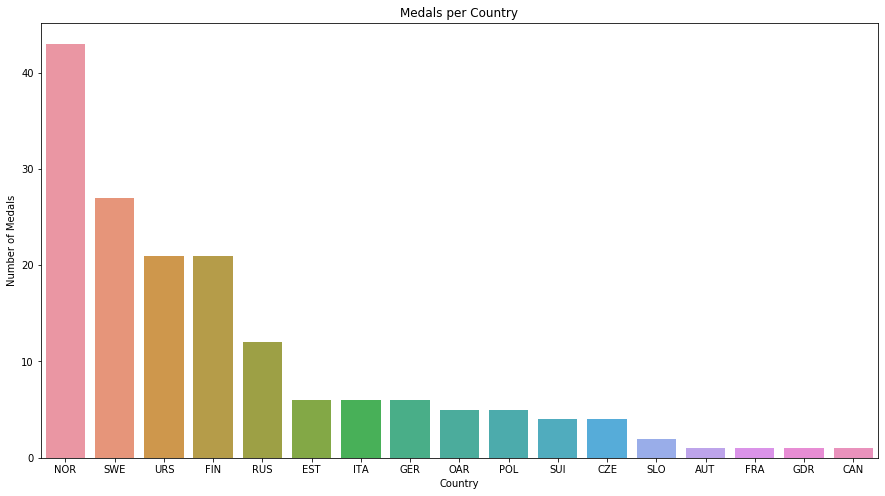

In [101]:
plt.figure(figsize=(15,8))
ax = sb.barplot(x=df.Country.value_counts().index, y=df.Country.value_counts())
ax.set(xlabel='Country', ylabel='Number of Medals')
ax.set_title('Medals per Country')

This is a plot of Total Medals won by country in cross-country skiing

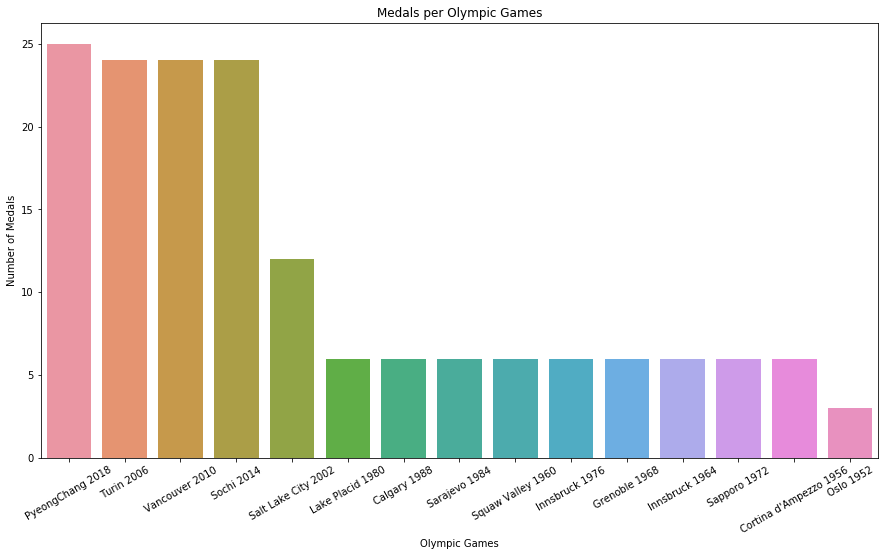

In [102]:
plt.figure(figsize=(15,8))
ax = sb.barplot(x=df.Olympics.value_counts().index, y=df.Olympics.value_counts())
ax.set(xlabel='Olympic Games', ylabel='Number of Medals')
ax.set_title('Medals per Olympic Games')
lbls = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

this chart represents the number of medals won by Olympic Games

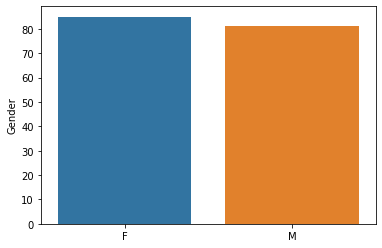

In [103]:
ax=sb.barplot(x=df['Gender'].value_counts().index, y=df['Gender'].value_counts())

this plot represents the number of athletes by gender. interestingly enough there are more female than male

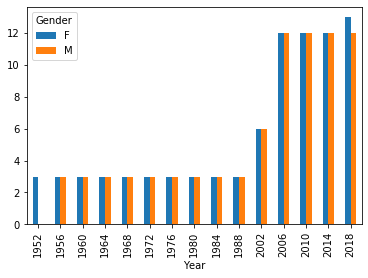

In [173]:
d = df.groupby(['Year', 'Gender']).count()['Event'].unstack().plot.bar()

this plot shows the number of male and female athletes by year

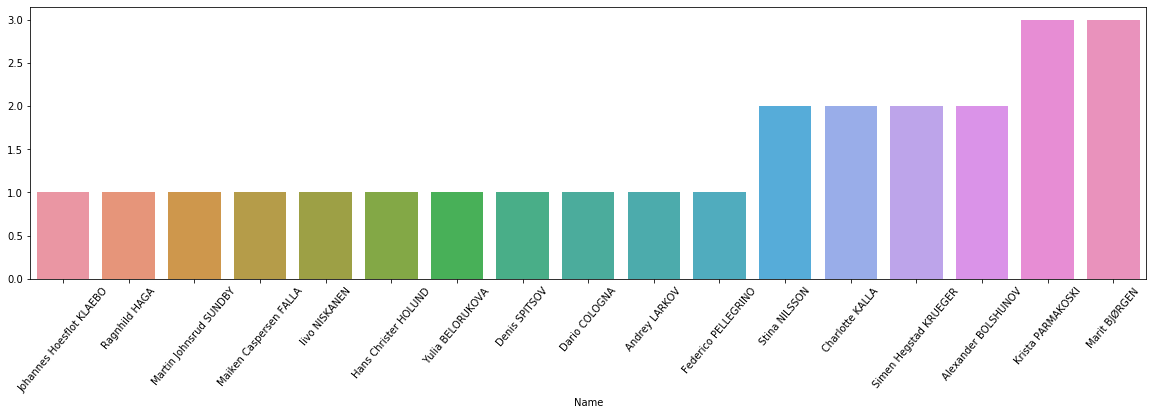

In [105]:
py18 = df.loc[df['Olympics'] == 'PyeongChang 2018']
py18_athletes = py18.groupby('Name').size().sort_values()
plt.figure(figsize=(20,5))
ax = sb.barplot(x=py18_athletes.index, y=py18_athletes)
lbls = ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

this is a chart of the athletes who won at the PyeongChang 2018 games and how many each one

#Solution and Statistical Test

Our question:

Do countries that win the olympics produce more winners over time, in cross country skiing?

In [0]:
country_wins = df.groupby(['Olympics','Country']).count()['Medal']
totals = country_wins.groupby('Country').sum().sort_values(ascending=False)

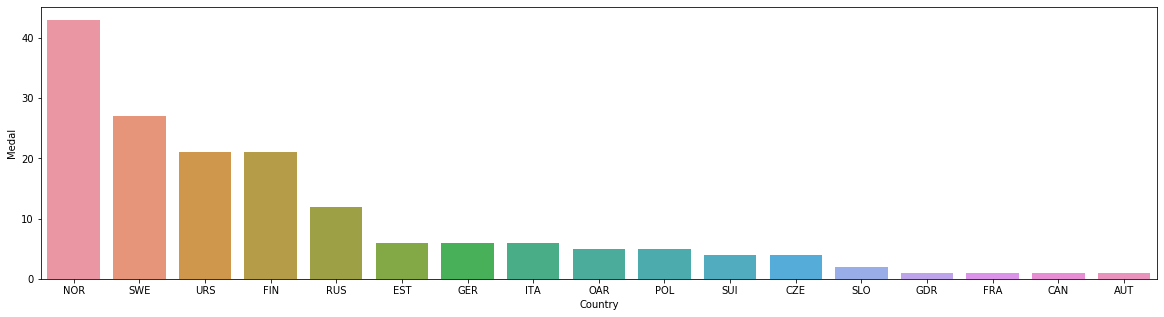

In [107]:
plt.figure(figsize=(20,5))
ax = sb.barplot(x=totals.index, y=totals)

This chart shows the number of medals each country has in cross-country skiing. Norway is the clear winner here, but does it have to do with more and more athletes winning over time or is it random?

In [0]:
nor = df.loc[df['Country'] == "NOR"]
nor_medals = nor.groupby('Year').count()['Medal'].sort_values()

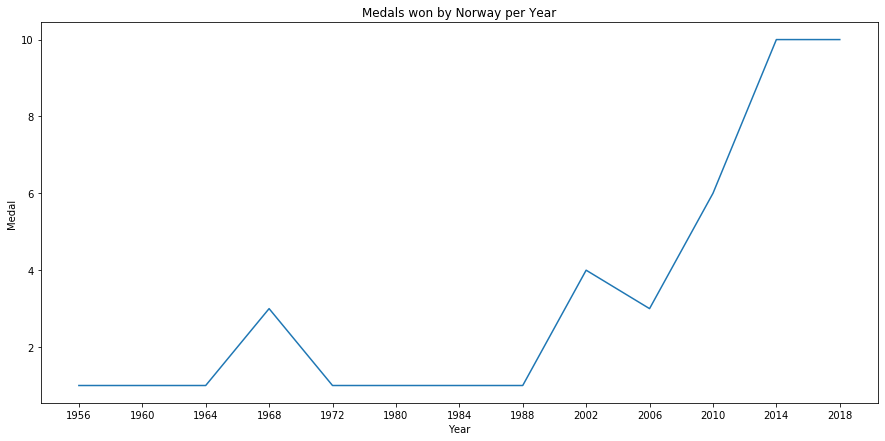

In [115]:
plt.figure(figsize=(15,7))
ax = sb.lineplot(x=nor_medals.index, y=nor_medals)
t = ax.set_title('Medals won by Norway per Year')

it appears that the medals won is random sinc norway didn't have an increasing chart

In [0]:
swe = df.loc[df['Country'] == 'SWE']
swe_medals = swe.groupby('Year').count()['Medal'].sort_values()

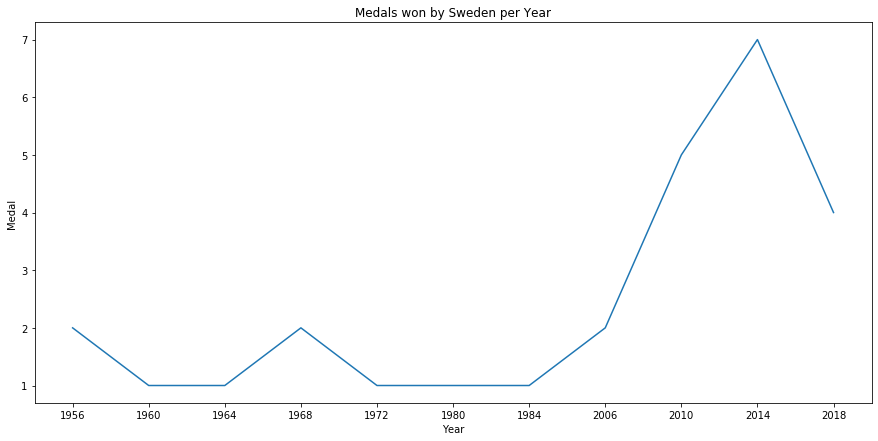

In [117]:
plt.figure(figsize=(15,7))
ax = sb.lineplot(x=swe_medals.index, y=swe_medals)
t = ax.set_title('Medals won by Sweden per Year')

Sweden's medal count by year is constant until 1984. then it increases and then decreases again in 2018

<Figure size 1080x504 with 0 Axes>

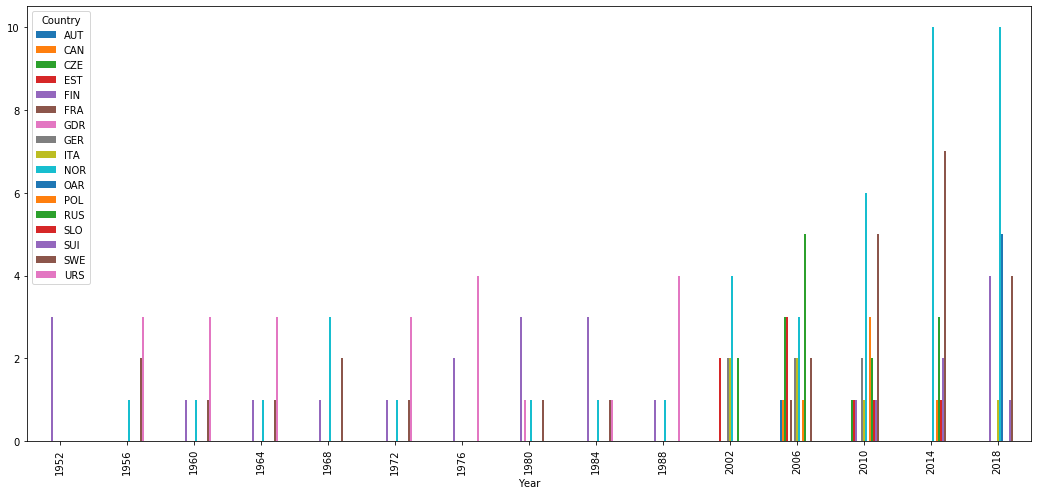

In [167]:
plt.figure(figsize=(15,7))
test = df.groupby(['Country','Year'])['Country'].count().unstack().transpose().fillna(0).plot.bar(figsize=(18,8))


plot of all the countries medals by year

In [172]:
countries = df.groupby(['Country', 'Year'])['Country'].count().unstack().fillna(0)
countries


Year,1952,1956,1960,1964,1968,1972,1976,1980,1984,1988,2002,2006,2010,2014,2018
Country,,,,,,,,,,,,,,,
AUT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CZE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
EST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0
FIN,3.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,0.0,0.0,1.0,0.0,4.0
FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GDR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0
ITA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0


there seems to be no effect on the countries wins per year and increasing wins for the subsequent games

#Conclusion and Analysis


I chose the dataset for Cross-Country Skiing Olympic medals because i am interested in the olympic event and enjoy watching it. It is also an important part of my family heritage.

The data was fairly simple to scrape and turn into a dataframe. I was easily able to get the data with the class names and child elements of those classes. There is not a ton of data, there's only 166 rows of data in the dataframe.

recall that the question asked during the analysis is: 

Do countries that win the olympics produce more winners over time, in cross country skiing?

I will conclude that the countries that win more consistently throughout the years seem to win more and more medals. For example, Norway and Sweden have both won consistently throughout history and have the most medals while other countries who don't win consistently only have 1 or 2 medals. So the answer to the question I believe is yes, the countries that win the olympics consistently produce more winners over time.